# Simulation and Inference for Neuroscience
## Exercises Week 3: Parameter inference for simulators in neuroscience

The notebook below contains the exercises for week 3.
The exercises are designed to follow the lecture material and do not need deep knowledge of python to be solved.

There are two types of exercises:
- **Tasks**: Where you need to write code, i.e. "implement a function that does X".
- **Questions**: Where you need to answer questions using the code you wrote. For example "vary the inputs and interpret the results", will require you to provide one or more plots together with your answer. To answer the questions you can use Markdown cells.

All necessary dependencies are imported in the first cell and you should not need to import anything else. In addition, we also provide some helper functions that can be used to help you answering the tasks. When solving the tasks, feel free to change the provided function signatures and code as you see fit. However, we recommend sticking with the provided signatures as they reflect common conventions and will make it easier to add additional functionality during the exercise. Type hints are provided for the function signatures and the arguments and each task should only require a few lines of code.

In [1]:
# configure jax to use 64bit precision and cpu
import jax
from jax import config

config.update("jax_enable_x64", True)
config.update("jax_platform_name", "cpu")

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".8"

In [2]:
# add the project root to the python path
import sys
sys.path.append("..")

# import the necessary dependencies
import matplotlib.pyplot as plt
import numpy as np
import optax
import torch
import jax
from jax import numpy as jnp
from jax import jit, vmap, value_and_grad

# jaxley imports
import jaxley as jx
from jaxley.channels import HH
from jaxley.stimulus import step_current
from jaxley.optimize.utils import l2_norm
from jaxley.optimize.transforms import SigmoidTransform, ParamTransform

# sbi imports
from sbi.utils import BoxUniform
from sbi.inference import SNPE
from sbi.analysis import pairplot

# Typing imports
from typing import Callable,Union, Optional, Tuple

In [74]:
torch.cuda.is_available()

True

In [75]:
# seed = torch.initial_seed()
# print(seed)
seed = 12270457759966295385
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
# utils
def plot_observation(
    t_obs: Union[jnp.ndarray, torch.tensor],
    v_obs: Union[jnp.ndarray, torch.tensor],
    i_obs: Optional[Union[jnp.ndarray, torch.tensor]] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the observed voltage and stimulus.

    If stimulus is provided it will create a figure with 2 axes, otherwise it will create a figure with 1 axis.

    Args:
        t_obs: The time points of the observed voltage and stimulus (ms).
        v_obs: The observed voltage (mV).
        i_obs: The observed stimulus (nA).

    Returns:
        fig: The figure.
        ax: The axes.
    """
    num_rows = 2 if i_obs is not None else 1
    height_ratios = [3, 1] if i_obs is not None else [1]
    fig, ax = plt.subplots(
        num_rows,
        1,
        figsize=(10, 5),
        sharex=True,
        gridspec_kw={"height_ratios": height_ratios},
    )
    if num_rows == 1:
        ax = [ax]
    ax[0].plot(t_obs, v_obs, c="k")
    ax[0].set_xlabel("t (ms)")
    ax[0].set_ylabel("V (mV)")
    if i_obs is not None:
        ax[1].plot(t_obs, i_obs, c="k")
        ax[1].set_xlabel("t (ms)")
        ax[1].set_ylabel("stimulus (nA)")
    return fig, ax


def make_plot(
    t_est: Union[jnp.ndarray, torch.tensor],
    v_est: Union[jnp.ndarray, torch.tensor],
    t_obs: Optional[Union[jnp.ndarray, torch.tensor]] = None,
    v_obs: Optional[Union[jnp.ndarray, torch.tensor]] = None,
    i_obs: Optional[Union[jnp.ndarray, torch.tensor]] = None,
) -> Tuple[plt.Figure, plt.Axes]:
    """Plot the estimated voltage and stimulus (along with the observed data if provided).

    Args:
        t_est: The time points of the estimated voltage (ms).
        v_est: The estimated voltage (mV).
        t_obs: The time points of the observed voltage (ms).
        v_obs: The observed voltage (mV).
        i_obs: The observed stimulus (nA).
    """
    if t_obs is not None:
        fig, ax = plot_observation(t_obs, v_obs, i_obs)
    else:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        ax = [ax]
    ax[0].plot(t_est, v_est, c="r", alpha=0.5)
    ax[0].set_xlabel("t (ms)")
    ax[0].set_ylabel("V (mV)")
    return fig, ax


# Infer parameters of a single compartment HH model

In week 1 we have learned how to simulate neural dynamics using the Hodgkin-Huxley model, i.e. going from parameters to observations. We call this the forward problem. 
In week 2 on the otherhand, you were introduced to methods that solve the so called inverse problem, i.e. going from observations to parameters. 
Now we will put these two together and see how we can combine simulation and inference methods to infer the parameters of a Hodgkin-Huxley model from a measured voltage trace.

Lets start by importing and looking at the data, before attempting to infer the model parameters at different levels of sophistication.

In [ ]:
# load observation (note that we convert the data to a jax array)

t_obs, v_obs, stim_obs = jnp.array(np.loadtxt("../data/observation.csv", unpack=True))
stim_amp = jnp.max(stim_obs)
# stim_obs


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Sampling interval:  0.25 ms
Max. time:  100.0 ms
Stimulus amplitude:  0.01 nA
Stimulus (end | duration | onset):  90.00 | 80.00 | 10.00 ms


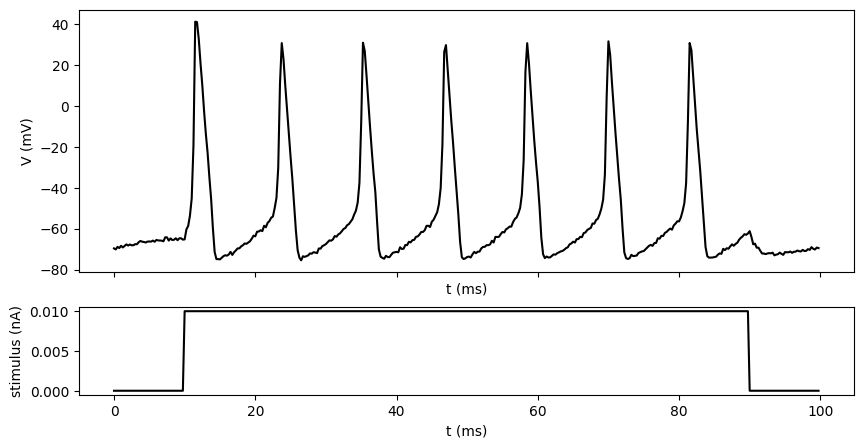

In [ ]:

# stimulus information
sampling_interval = t_obs[1] - t_obs[0]
stim_amp = jnp.max(stim_obs)
stim_onset = t_obs[stim_obs.nonzero()][0]
stim_end = t_obs[stim_obs.nonzero()][-1] + sampling_interval
stim_dur = stim_end - stim_onset
t_max = t_obs[-1] + sampling_interval

print("Sampling interval: ", sampling_interval, "ms")
print("Max. time: ", t_max, "ms")
print("Stimulus amplitude: ", stim_amp, "nA")
print("Stimulus (end | duration | onset): ", f"{stim_end:.2f} | {stim_dur:.2f} | {stim_onset:.2f} ms")

# plot the observation
plot_observation(t_obs, v_obs, i_obs=stim_obs)
plt.show()


## Hand-tuning
Arguably the most simple approach to solve the inverse problem is just by "trial and error" or hand tuning the parameters. How difficult this can already be for just 3 parameters, we will explore in the following:

### Tasks
- Implement a simulator for a single compartment HH model in `jaxley`
    - For details see the [documentation](https://jaxley.readthedocs.io/en/latest/index.html)
- hand-tune (manually vary) the different conductances $g_{Na}$, $g_{K}$, $g_{leak}$ to fit a single compartment HH model to the measured voltage trace.
- plot the results

### Questions
- How do you assess the quality of the fit, i.e. what (characteristics) do you look for?
- What are ways to quantify this?

_Note: don't forget to set the initial conditions_

In [76]:
print("Sampling interval: ", sampling_interval, "ms")
print("Max. time: ", t_max, "ms")
print("Stimulus amplitude: ", stim_amp, "nA")
print("Stimulus (end | duration | onset): ", f"{stim_end:.2f} | {stim_dur:.2f} | {stim_onset:.2f} ms")

Sampling interval:  0.25 ms
Max. time:  100.0 ms
Stimulus amplitude:  0.01 nA
Stimulus (end | duration | onset):  90.00 | 80.00 | 10.00 ms


In [77]:
# stimulus information
sampling_interval = t_obs[1] - t_obs[0]
stim_amp = jnp.max(stim_obs)
stim_onset = t_obs[stim_obs.nonzero()][0]
stim_end = t_obs[stim_obs.nonzero()][-1] + sampling_interval
stim_dur = stim_end - stim_onset
stim_dur


Array(80., dtype=float64)

In [78]:
# Set up the simulation

# NOTE: Keep in mind that the stepsize of the solver is 1/10th of the sampling interval of our experimental data!
dt = 0.025
# current = jx.step_current(i_delay=1.0, i_dur=1.0, i_amp=0.1, delta_t=0.025, t_max=10.0)

# define the stimulus
stimulus = step_current(
    # add the stimulus parameters here
    i_delay=stim_onset, i_dur=stim_dur, i_amp=stim_amp, delta_t=dt, t_max=t_max
)
ts = jnp.arange(
    t_obs[0], t_max, dt
)

# create a single compartment HH model, add a stimulus and record the voltage

comp = jx.Compartment()
comp.insert(HH())
# define the model here 
# add a recording and stimulation here ()
comp.record(state="v")
comp.stimulate(jnp.array(stimulus))
# set the initial conditions
# initialize the model
comp.init_states(dt)
# define a simulator
@jit
def simulate(params: dict[str, jnp.ndarray]) -> jnp.ndarray:
    """Simulate the HH model for the given parameters.

    Note that we are using `@jit` to compile the function before running it.
    Since we are running the function a lot of times, it is worth the addtional overhead 
    to compile it first.
    
    Args:
        params: The parameters of the HH model.

    Returns:
        v: The voltage trace.
    """
    # set the simulation parameters to update the model
    pstate = None
    for key, value in params.items():
        pstate = comp.data_set(key, value, pstate)

    # integrate the model
    v = jx.integrate(comp, param_state=pstate, delta_t=dt)
    return v[:, :len(ts)] # match length to ts


Added 1 recordings. See `.recordings` for details.
Added 1 external_states. See `.externals` for details.


In [79]:
# define the parameter bounds
lb = {"HH_gNa": 1e-3, "HH_gK": 1e-3, "HH_gLeak": 1e-5}
ub = {"HH_gNa": 1.0, "HH_gK": 1.0, "HH_gLeak": 1e-3}
bounds = {k:(lb,ub) for k, (lb, ub) in zip(lb.keys(), zip(lb.values(), ub.values()))}

(<Figure size 1000x500 with 1 Axes>,
 [<Axes: xlabel='t (ms)', ylabel='V (mV)'>])

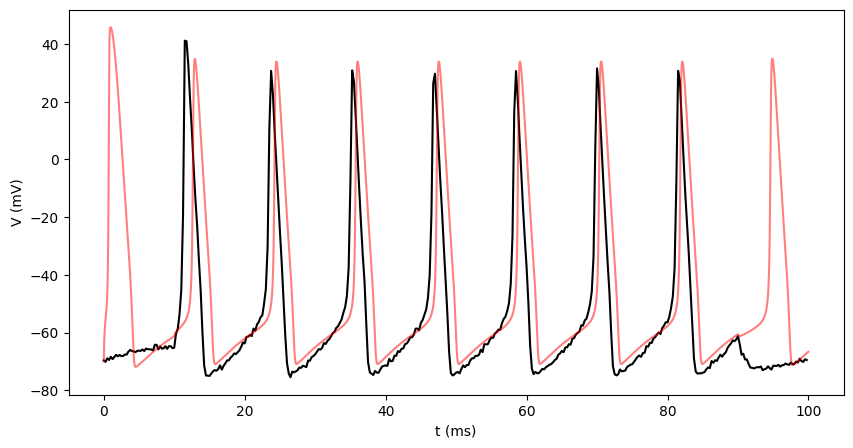

In [80]:
# hand-tune the parameters
param_guess = {"HH_gNa": jnp.array([0.95]), "HH_gK": jnp.array([0.1]), "HH_gLeak": jnp.array([0.01])}
v_guess = simulate(param_guess)

# plot the voltage trace
make_plot(ts , v_guess.flatten() , t_obs , v_obs )

## Random / Grid search
While hand-tuning is a very simple method that can work for a few parameters, you should have noticed that this is already tricky for just 3 parameters and it will quickly become infeasible for more complex models and larger parameter spaces. Therefore we will explore a still simple, but more systematic approach: random / grid search.

### Tasks
- Implement a mean absolute error loss
- Implement **either** a random **or** a grid search to find suitable parameters
- Plot your top 10 results as quantified by their mean absolute error

### Questions
- Are the results what you expected? Why / Why not?
- What are different ways in which you could improve the results?

In [81]:
# parallelize the simulation (for more details see https://docs.jax.dev/en/latest/_autosummary/jax.vmap.html)
# this way you can input an entire batch of parameters rather than having to loop over them
parallel_simulate = vmap(simulate)

# define an error / distance function
def mean_abs_err(v_est: jnp.ndarray, v_true: jnp.ndarray) -> jnp.ndarray:
    """Compute the mean absolute error between the estimated and observed voltage trace.
    
    Args:
        v_est: The estimated voltage trace.
        v_true: The true voltage trace.

    Returns:
        err: The mean absolute error.
    """
    
    
    # Compute mean along the time axis if input is batched
    return jnp.mean(jnp.abs(v_est - v_true), axis=-1)  # implement the mean absolute error here


In [12]:
# sample a batch of parameter (randomly or on a grid)

# grid-search
gridsize = (20, 20, 20)

# random search
num_samples = 10_000

In [84]:
import jax.numpy as jnp

# Number of points per parameter
n_points = 40

# Create evenly spaced values for each parameter
HH_gNa_grid = jnp.linspace(lb['HH_gNa'], ub['HH_gNa'], n_points)
HH_gK_grid = jnp.linspace(lb['HH_gK'], ub['HH_gK'], n_points)
HH_gLeak_grid = jnp.linspace(lb['HH_gLeak'], ub['HH_gLeak'], n_points)

# Create the grid using meshgrid
HH_gNa, HH_gK, HH_gLeak = jnp.meshgrid(HH_gNa_grid, HH_gK_grid, HH_gLeak_grid)
param_grid = jnp.stack([HH_gNa.ravel(), HH_gK.ravel(), HH_gLeak.ravel()], axis=1)

# Parameter dictionary for simulation
param_guess = {
    "HH_gNa": param_grid[:, 0],
    "HH_gK": param_grid[:, 1],
    "HH_gLeak": param_grid[:, 2]
}

In [85]:
param_grid.shape

(64000, 3)

In [86]:
# simulate the batch of parameters
v_samples = parallel_simulate(param_guess)


In [87]:
samples = v_samples.squeeze(1)
samples.shape

(64000, 4000)

In [88]:
err = mean_abs_err(samples[:,::10], v_obs)
err.shape

(64000,)

In [89]:
# get the top 10 results
top_indices =  jnp.argsort(err)[ :10]  
err[top_indices]


Array([ 6.83356141,  7.07886032,  7.36291665,  7.80323612,  8.51744206,
       10.72654106, 11.33066838, 11.50700505, 11.60867739, 11.96361031],      dtype=float64)

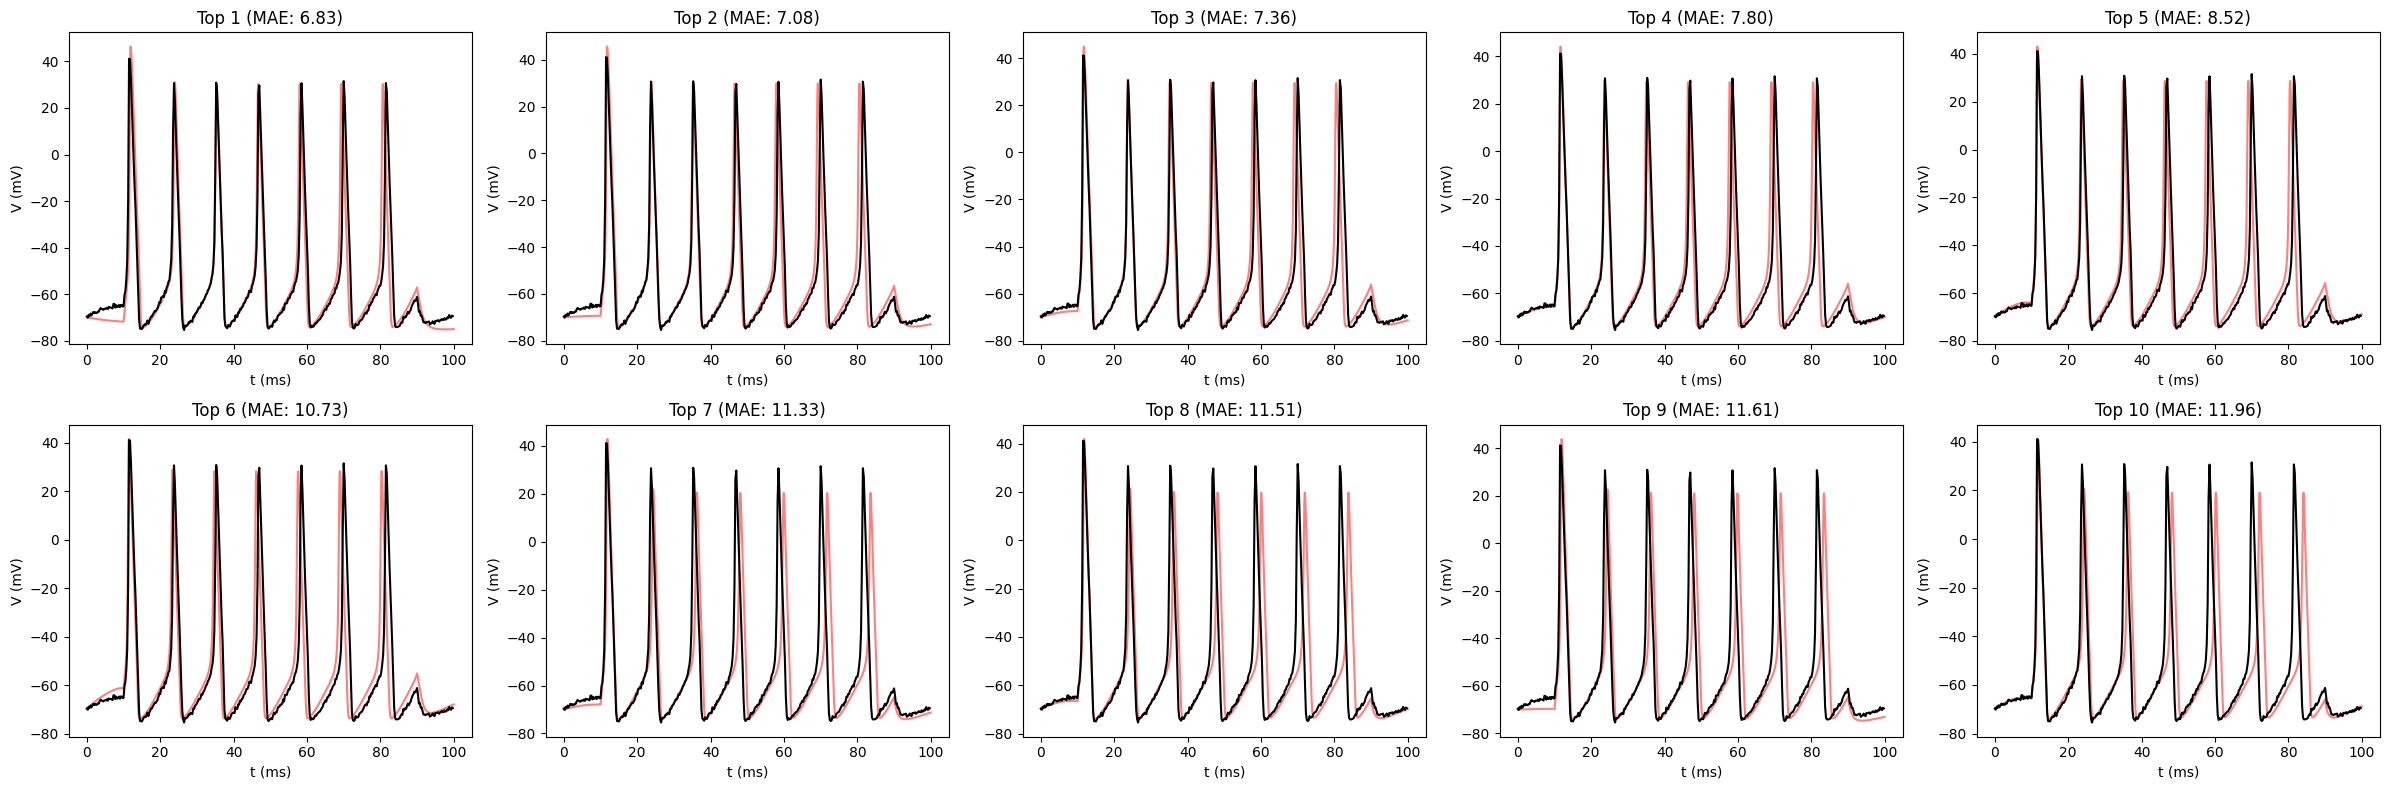

In [90]:
# plot the top 10 results and compare them with the observation
# single plot with 10 axes
fig, axes = plt.subplots(2, 5, figsize=(24, 8))
for i, idx in enumerate(top_indices):
    v_est = v_samples[idx,0]
    ax = axes[i // 5, i % 5]
    ax.plot(ts, v_est, c="r", alpha=0.5)
    ax.plot(t_obs, v_obs, c="k")
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("V (mV)")
    ax.set_title(f"Top {i+1} (MAE: {err[idx]:.2f})")
plt.tight_layout()
plt.show()

## Rejection ABC
While using random and grid searches to sample the parameter space can yield good results, they struggle to deal with uncertainty and noisy data. Bayesian inference tries to alleviate this by infering a posterior distribution, rather than a point estimate. Unfortunately, most simulators have intractable likelihood functions however and hence we can only approximately do Bayesian inference (Approximate Bayesian Computation, ABC). One method to do this is called rejection ABC, where we approximate the posterior using samples from the simulator.

### Tasks
- Implement a rejection ABC sampler using the mean squared error as a distance metric
- Sample the parameter space
- Plot your top 10 parameter samples. Compare them to the previous best samples
- Play around with the threshold to see how it affects the results

### Questions
- Are the results what you expected? Why / Why not?
- What are different ways in which you could improve the results?

_Note you can use the `mean_abs_err` function you defined before._

In [91]:
# implement the rejection ABC sampler
def rejection_abc(num_samples: int, threshold: float, distance_fn: Callable[[jnp.ndarray, jnp.ndarray], jnp.ndarray] = mean_abs_err) -> Tuple[dict[str, jnp.ndarray], jnp.ndarray, jnp.ndarray]:
    """Rejection ABC sampler.
    
    Args:
        num_samples: The number of samples to draw.
        threshold: The threshold for the distance.
        distance_fn: The distance function.
    """
    # Sample parameters from prior
    rng = jax.random.split(jax.random.PRNGKey(0), len(bounds))
    samples = {k: jax.random.uniform(sub_rng, (num_samples,), minval=lb, maxval=ub) 
               for sub_rng, (k, (lb, ub)) in zip(rng, bounds.items())}
    
    # Simulate for all parameter samples
    v_samples = parallel_simulate(samples)
    
    # Calculate distances
    distances = distance_fn(v_samples[:,0,::10] ,v_obs )
    
    # Select samples below threshold
    accepted_indices = jnp.where(distances < threshold)

    accepted_params = {k: v[accepted_indices] for k, v in samples.items()}
    accepted_distances = distances[accepted_indices]
    
    return accepted_params, accepted_distances, v_samples[accepted_indices]

In [95]:
# Run rejection ABC
num_samples = 10_000
threshold = 13  # You may need to adjust this based on your data
accepted_params, accepted_distances, accepted_v = rejection_abc(num_samples, threshold)

# Sort by distance to get the best fits
sorted_indices = jnp.argsort(accepted_distances)
top_indices = sorted_indices[:10]  # Get top 10

In [96]:
accepted_samples = torch.tensor(np.array(list(accepted_params.values())).T)
accepted_samples.shape

torch.Size([70, 3])

(<Figure size 1000x1000 with 9 Axes>,
 array([[<Axes: xlabel='dim 1'>, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: xlabel='dim 2'>, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: xlabel='dim 3'>]], dtype=object))

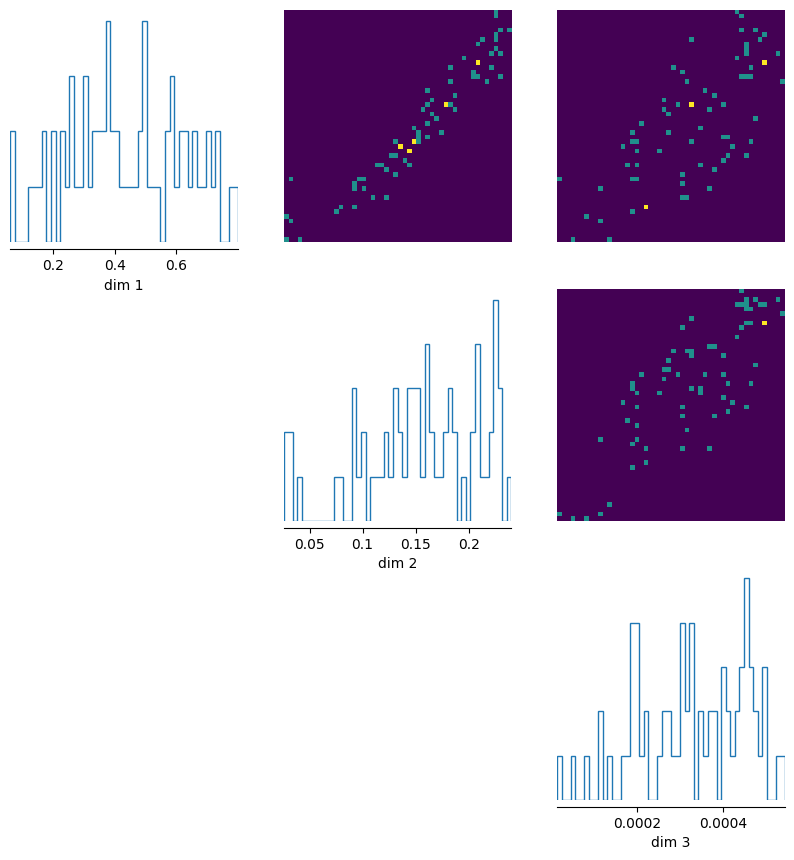

In [97]:
# visualize the estimated posterior within the prior bounds using `pairplot`
# Note the pairplot expects a torch tensor as input
# you can learn more about `pairplot` if you run `?pairplot`
accepted_samples = torch.tensor(np.array(list(accepted_params.values())).T)
# plot the distributionpairplot
pairplot(accepted_samples )

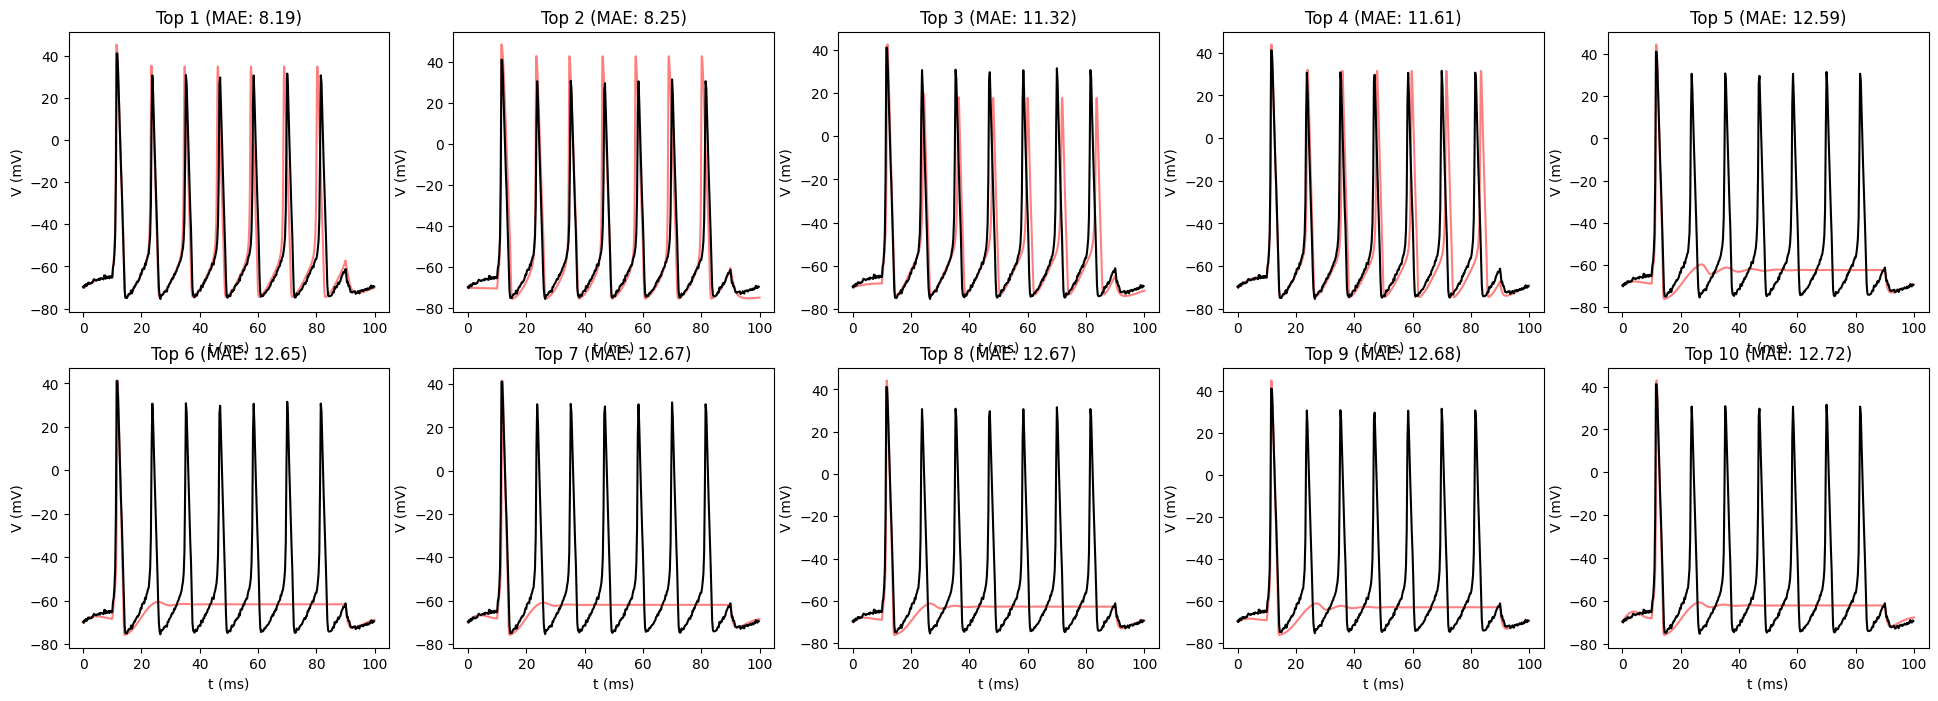

In [98]:
# Plot top voltage traces of the top 10 parameter samples
fig, axes = plt.subplots(2, 5, figsize=(24, 8))
for i, idx in enumerate(top_indices):
    v_est = accepted_v[idx,0]
    ax = axes[i // 5, i % 5]
    ax.plot(ts, v_est, c="r", alpha=0.5)
    ax.plot(t_obs, v_obs, c="k")
    ax.set_xlabel("t (ms)")
    ax.set_ylabel("V (mV)")
    ax.set_title(f"Top {i+1} (MAE: {accepted_distances[idx]:.2f})")

## Rejection ABC (with features)
Rather than computing the distance on the raw voltage traces of the HH model, it can be beneficial to compute the distance on a lower dimensional representation of the data. This is computationally much easier and more robust. A common approach to reduce the dimensionality of the data is to compute so called summary features, which are able to capture more of the global structure of the data. 

### Tasks
- Implement a distance metric based on summary features
    - How could you quantify global charecteristics of the voltage trace? Think of statistical properties.
    - Come up with your own summary features and implement them
- Run the rejection ABC sampler again with the new distance metric
- Plot your top 10 parameter samples. Compare them to the previous best samples
- Play around with the threshold to see how it affects the results

### Questions
- How do the results compare to the previous results? Which ones would you consider to be better?
- What are ways in which you could improve the results even further?

In [ ]:
def compute_summary_stats_np(v: jnp.ndarray) -> jnp.ndarray:
    """Compute summary statistics of the voltage trace.
    
    A feature can be anything that takes the time series as input and returns a single number.

    Args:
        v: The voltage trace.

    Returns:
        summary_stats: The summary statistics.
    """
    # print(v.shape)
    ft1 = np.mean(v, axis=-1)
    ft2 = np.std(v, axis=-1)
    ft3 = np.max(v, axis=-1)
    ft4 = np.min(v, axis=-1)
    # ft5 = np.sum(v, axis=-1)
    # print(ft1.shape)
    # return ft1, ft2, ft3
    return jnp.stack([ft1, ft2, ft3, ft4], axis=-1)


def fts_err(v_est: jnp.ndarray, v_true: jnp.ndarray) -> jnp.ndarray:
    """Compute a feature based distance.

    ```
    fts_est = compute_summary_stats(v_est)
    fts_true = compute_summary_stats(v_true)

    fts_err = sum(jnp.abs(fts_est - fts_true))
    ```
    
    Args:
        v_est: The estimated voltage trace.
        v_true: The true voltage trace.

    Returns:
        ft_err: The feature based distance.
    """
    # implement the feature based distance here
  
    fts_est = compute_summary_stats_np(v_est)
    fts_true = compute_summary_stats_np(v_true[None,:])
    fts_err = jnp.mean(jnp.abs(fts_est - fts_true), axis=-1)
    return fts_err

In [106]:
a = compute_summary_stats_np(jnp.ones((100, 10)))
a[0].shape
jnp.stack(a, axis=-1).shape

(4, 100)

In [107]:
# Run rejection ABC
num_samples = 10_000
threshold = 2  # You may need to adjust this based on your data
accepted_params, accepted_distances, accepted_v = rejection_abc(num_samples, threshold, fts_err)

# Sort by distance to get the best fits
sorted_indices = jnp.argsort(accepted_distances)
top_indices =  sorted_indices[:10] # Get top 10

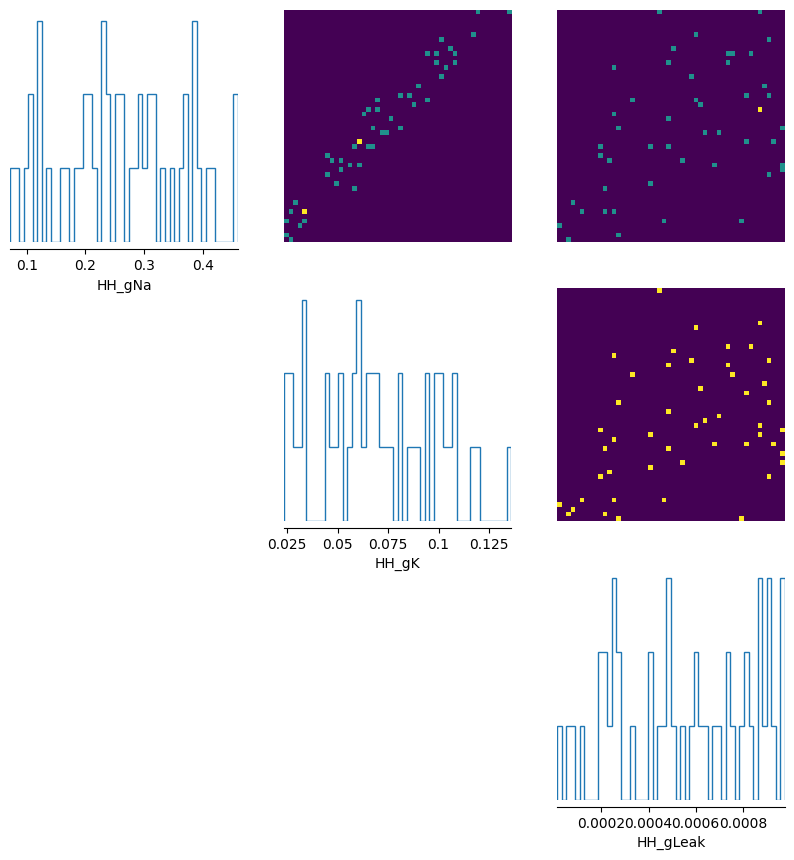

In [108]:
# visualize the estimated posterior within the prior bounds using `pairplot`
# Note the pairplot expects a torch tensor as input
accepted_samples = torch.tensor(np.array(list(accepted_params.values())).T)
# plot the distribution
pairplot(accepted_samples, labels=list(bounds.keys()))
plt.show()

In [109]:
# Plot top 10 simulations

## Neural Posterior Estimation

While rejection ABC provides a more principled approach than grid or random searches, it can become inefficient as the dimensionality of the parameter space increases or when the simulator is computationally expensive. Neural Posterior Estimation (NPE) addresses these limitations by using neural networks to learn an approximation of the posterior distribution directly from simulation data.

NPE leverages the power of conditional density estimation to build a model that maps from observed data to the corresponding posterior distribution over parameters. This approach often requires fewer simulations than traditional ABC methods and can capture complex posterior distributions more effectively.

### Tasks
- Implement NPE using the `sbi` package, use the lower dimensional summary features as input. For details see the [documentation](https://sbi-dev.github.io/sbi/0.22/)
    - Use one round of `SNPE` for that
    - use a MDN as a density estimator (run `?SNPE` for details)
    - reimplement the `compute_summary_stats` function to work with torch tensors
- plot the posterior
- compute the MAP estimate

### Questions
- Under what circumstances might NPE be preferable to rejection ABC, and vice versa?
- How do the posterior estimates from NPE compare to those from rejection ABC in terms of accuracy and efficiency?

_Note: the `sbi` package is based on pytorch and hence expects `torch.tensors` as inputs and outputs. These work similarly to numpy arrays and also come with similar functions, i.e `torch.sum` etc. Use the [documentation](https://sbi-dev.github.io/sbi/0.22/) to answer your questions._

torch.Size([5, 1, 4000])

In [136]:
dummy = torch.rand(size=(100,400))
torch.max(dummy, axis=-1)[0], torch.max(dummy, axis=-1)[0].shape

(tensor([0.9998, 0.9992, 0.9989, 0.9991, 0.9959, 0.9952, 0.9942, 0.9998, 0.9961,
         0.9978, 0.9964, 0.9976, 0.9991, 0.9964, 0.9994, 0.9994, 0.9992, 0.9974,
         0.9957, 0.9985, 0.9949, 0.9998, 0.9999, 0.9995, 0.9988, 0.9980, 0.9989,
         0.9963, 0.9997, 0.9973, 0.9995, 0.9983, 0.9967, 0.9993, 0.9994, 0.9981,
         0.9996, 0.9991, 0.9997, 0.9982, 0.9998, 0.9929, 0.9961, 0.9975, 0.9982,
         0.9966, 0.9995, 0.9993, 0.9999, 0.9984, 0.9940, 0.9935, 0.9974, 0.9990,
         0.9994, 0.9973, 0.9974, 0.9992, 0.9977, 0.9998, 0.9973, 0.9993, 0.9962,
         0.9971, 0.9963, 0.9979, 0.9969, 0.9945, 0.9990, 0.9977, 0.9990, 0.9964,
         0.9974, 0.9997, 0.9948, 0.9983, 0.9993, 0.9963, 0.9992, 0.9987, 0.9980,
         0.9994, 0.9963, 0.9963, 0.9969, 0.9942, 0.9957, 0.9981, 0.9971, 0.9947,
         0.9998, 0.9936, 1.0000, 0.9930, 0.9954, 0.9945, 0.9992, 0.9964, 0.9997,
         0.9999]),
 torch.Size([100]))

In [166]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [174]:
# define Uniform prior for the parameters
B = torch.tensor(list(bounds.values()), dtype=torch.float32)

prior = BoxUniform(low=B[:,0],high = B[:,1] ,  device=device) # use the parameter bounds
# prior.to(device)
# reimplement the summary statistics function to work with torch tensors or 
# wrap the numpy function to work with torch tensors
def compute_summary_stats_torch(x: torch.tensor) -> torch.tensor:
    """Compute summary statistics of the voltage trace.
    
    Args:
        x: The voltage trace.

    Returns:
        summary_stats: The summary statistics.
    """
    # x = torch.tensor(x,dtype=torch.float32)
    ft1 = torch.mean(x, axis=-1)
    ft2 = torch.std(x, axis=-1)
    ft3 = torch.max(x, axis=-1)[0]
    ft4 = torch.min(x, axis=-1)[0]
    return torch.stack([ft1, ft2, ft3, ft4], axis=-1)

# simulator function for sbi
def simulate_for_sbi(theta: torch.tensor) -> torch.tensor:
    """Simulate the HH model for the given parameters.
    
    Args:
        theta: The parameters of the HH model.

    Returns:
        v: The voltage trace.
    """
    # since jaxley expects jax arrays and sbi uses torch tensors
    # we need to convert theta back and forth
    theta = theta.cpu()
    theta = theta.numpy()
    theta = {k:v for k,v in zip(bounds.keys(), theta.T)}
    return torch.tensor(parallel_simulate(theta)).to(torch.float32)


/home/asim/Desktop/AIMS2025-NeuroSimInf/.venv/lib/python3.12/site-packages/sbi/utils/torchutils.py:27: UserWarning: GPU was selected as a device for training the neural network. Note that we expect no significant speed ups in training for the default architectures we provide. Using the GPU will be effective only for large neural networks with operations that are fast on the GPU, e.g., for a CNN or RNN `embedding_net`.
  warnings.warn(


In [175]:
# prior = BoxUniform(low=B[:,0],high = B[:,1]) # use the parameter bounds
# p = prior.sample(sample_shape=(5,))
# simulate_for_sbi(p).squeeze().shape
# compute_summary_stats_torch(simulate_for_sbi(p).squeeze()).shape


In [176]:
torch.manual_seed(0)

# draw samples from the prior, simulate and compute summary statistics
theta_train = prior.sample(sample_shape=(10000,)).to(device)
v_train = simulate_for_sbi(theta_train).to(device)
x_train = compute_summary_stats_torch(v_train).to(device)
x_obs = compute_summary_stats_torch(torch.tensor(v_obs).unsqueeze(0)).to(device)

# run NPE (one round of SNPE)
snpe = SNPE(prior = prior, density_estimator='mdn', device='cuda')
infer = snpe.append_simulations(theta_train, x_train, data_device='cuda')
estimator = infer.train()
posterior =snpe.build_posterior(estimator, prior=theta_train)

/home/asim/Desktop/AIMS2025-NeuroSimInf/.venv/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:720: UserWarning: Data x has device 'cuda:0'.Moving x to the data_device 'cuda'.Training will proceed on device 'cuda:0'.
  warnings.warn(
/home/asim/Desktop/AIMS2025-NeuroSimInf/.venv/lib/python3.12/site-packages/sbi/utils/user_input_checks.py:728: UserWarning: Parameters theta has device 'cuda:0'. Moving theta to the data_device 'cuda'.Training will proceed on device 'cuda:0'.
  warnings.warn(


 Neural network successfully converged after 263 epochs.

AssertionError: Prior must be a PyTorch Distribution. See FAQ 7 for more details or use
        `sbi.utils.user_input_checks.process_prior` for wrapping scipy and lists of
        independent priors.

In [ ]:
?SNPE

Init signature:
SNPE(
    prior: Optional[torch.distributions.distribution.Distribution] = None,
    density_estimator: Union[str, Callable] = 'maf',
    device: str = 'cpu',
    logging_level: Union[int, str] = 'WARNING',
    summary_writer: Optional[sbi.types.Writer] = None,
    show_progress_bars: bool = True,
)
Docstring:      Abstract base class for neural inference methods.
Init docstring:
SNPE-C / APT [1].

[1] _Automatic Posterior Transformation for Likelihood-free Inference_,
    Greenberg et al., ICML 2019, https://arxiv.org/abs/1905.07488.

This class implements two loss variants of SNPE-C: the non-atomic and the atomic
version. The atomic loss of SNPE-C can be used for any density estimator,
i.e. also for normalizing flows. However, it suffers from leakage issues. On
the other hand, the non-atomic loss can only be used only if the proposal
distribution is a mixture of Gaussians, the density estimator is a mixture of
Gaussians, and the prior is either Gaussian or Uniform. It

In [ ]:
# condition the posterior on the observed data
posterior.set_default_x(x_obs)

# sample from the posterior
samples = 

# get the top 10 results and simulate them
top_indices = 
v_top = 

# compute the MAP estimate
theta_map = 
print(f"MAP estimate: gNa={theta_map[:, 0].item():.3f}, gK={theta_map[:, 1].item():.3f}, gLeak={theta_map[:, 2].item():.3f}")

In [ ]:
# visualize the estimated posterior within the prior bounds using `pairplot`and the MAP estimate
# Note the pairplot expects a torch tensor as input

In [ ]:
# plot the top 10 results

## Gradient Descent via Backpropagation of Error
While sampling-based methods like ABC and Neural Posterior Estimation provide distributional estimates of parameters, optimization approaches offer an alternative strategy when we primarily seek point estimates. This can be especially useful when the simulator is computationally expensive but gradients over the simulator parameters are available, since gradient-based optimization usually requires many fewer evaluations of the simulator compared to sampling-based methods.


### Tasks
- Optimize parameters directly on the time series data using gradient descent
- Bonus: Optimize using summary statistics as an alternative approach

### Questions
- How do the results compare to the ones from SBI methods?
- How do the results from the feature based approach compare to the ones from the mean squared error loss?
- What are ways to make the optimization process more robust to local minima?

_Note: to ensure that the parameters are optimized within their bounds, we use use sigmoid to transform between the interval [a,b] <-> [-inf,inf]. You can use the [documentation](https://jaxley.readthedocs.io/en/latest/index.html) and [tutorials](https://jaxley.readthedocs.io/en/latest/tutorials.html) to help you answer the questions._

In [38]:
transform = jx.ParamTransform({k:SigmoidTransform(lb[k], ub[k]) for k in bounds.keys()})

# define the loss function
def loss(params: jnp.ndarray) -> jnp.ndarray:
    """Compute the mean absolute error between the estimated and observed voltage trace.
    
    Args:
        params: The parameters of the HH model.

    Returns:
        loss: The mean absolute error.
    """
    params = transform.forward(params) # transform the parameters
    v_est = 
    err = 
    return err

diff = jit(value_and_grad(loss)) # take the gradient of the loss function (and use jit to speed up the computation)

In [ ]:
# define the optimizer and initialize the parameters (you can play around with the learning rate, number of epochs, etc.)
lr = 1e-1
max_epochs = 5000
init_params = {"HH_gNa": 0.12, "HH_gK": 0.3, "HH_gLeak": 0.0003}
opt_params = transform.inverse(init_params)
optimizer = optax.adam(learning_rate=lr)
opt_state = optimizer.init(opt_params)

# run the optimization

# loop over the epochs
    loss_val, grad_val = # obtain the gradient and value of the loss function

    updates, opt_state = optimizer.update(grad_val, opt_state)
    opt_params = optax.apply_updates(opt_params, updates)
    
# get the final parameters
final_params = transform.forward(opt_params)

In [ ]:
# simulate the final parameters

# plot the results